# 1. Intro

***Goal: Classification of default given client features***

In this notebook, we are going to:

1. Explore the effect of using different sets of features on different evaluation metrics.
2. Compare the performance of an ensemble methods (Random Forest) to a Boosting method (CatBoost).
3. Evaluate which model performs better in regards to precision and recall.

In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.feature_selection import RFE

file_path = 'UCI_Credit_Card.csv'

# 2. Exploring the data

In [2]:
df = pd.read_csv(file_path)

# Show the first few rows of the dataset
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
# Check for any nan values
df.isna().any()

ID                            False
LIMIT_BAL                     False
SEX                           False
EDUCATION                     False
MARRIAGE                      False
AGE                           False
PAY_0                         False
PAY_2                         False
PAY_3                         False
PAY_4                         False
PAY_5                         False
PAY_6                         False
BILL_AMT1                     False
BILL_AMT2                     False
BILL_AMT3                     False
BILL_AMT4                     False
BILL_AMT5                     False
BILL_AMT6                     False
PAY_AMT1                      False
PAY_AMT2                      False
PAY_AMT3                      False
PAY_AMT4                      False
PAY_AMT5                      False
PAY_AMT6                      False
default.payment.next.month    False
dtype: bool

The dataset has 1 column for identification, 23 features and one target:

- `ID`: Identifier for each individual in the dataset
- `LIMIT_BAL`: Credit limit
- `SEX`: Gender (1 = male; 2 = female)
- `EDUCATION`: Level of education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
- `MARRIAGE`: Marital status (1 = married; 2 = single; 3 = others)
- `AGE`: Age in years
- `PAY_0, PAY_2, ..., PAY_6`: Repayment status for the past months (scale from -2 to 8, where -2 = no consumption; -1 = paid in full; 0 = the use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months)
- `BILL_AMT1, BILL_AMT2, ..., BILL_AMT6`: Amount of bill statement for the past months
- `PAY_AMT1, PAY_AMT2, ..., PAY_AMT6`: Amount paid in the past months
- `default.payment.next.month`: Whether the person defaulted the next month (1 = yes; 0 = no). The actual target here

In [62]:
target = 'default.payment.next.month'
# Check balancing of the target
df[target].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

Important point: The dataset shows ***imbalance*** regarding the target.

In [6]:
# Calculate the Spearman correlation matrix
spearman_correlation_matrix = df.corr(method='spearman')

# Filter the correlation values related to the target variable 'default.payment.next.month'
spearman_target_correlation = spearman_correlation_matrix[target].sort_values(ascending=False)
spearman_target_correlation

default.payment.next.month    1.000000
PAY_0                         0.292213
PAY_2                         0.216919
PAY_3                         0.194771
PAY_4                         0.173690
PAY_5                         0.159043
PAY_6                         0.142523
EDUCATION                     0.044369
AGE                           0.005149
BILL_AMT6                    -0.000076
BILL_AMT5                    -0.006851
BILL_AMT4                    -0.008357
BILL_AMT3                    -0.012670
ID                           -0.013952
BILL_AMT2                    -0.015554
BILL_AMT1                    -0.025327
MARRIAGE                     -0.026490
SEX                          -0.039961
PAY_AMT5                     -0.116587
PAY_AMT6                     -0.121444
PAY_AMT4                     -0.127979
PAY_AMT3                     -0.139388
PAY_AMT2                     -0.150977
PAY_AMT1                     -0.160493
LIMIT_BAL                    -0.169586
Name: default.payment.nex

The Spearman correlation coefficients between the features and the target variable `default.payment.next.month` are as follows:

### Positive Correlation:
- `PAY_0`: 0.292
- `PAY_2`: 0.217
- `PAY_3`: 0.195
- `PAY_4`: 0.174
- `PAY_5`: 0.159
- `PAY_6`: 0.143

### Negligible Correlation:
- `EDUCATION`: 0.044
- `AGE`: 0.005
- `BILL_AMT1` to `BILL_AMT6`: Nearly zero
- `ID`: -0.014
- `MARRIAGE`: -0.026
- `SEX`: -0.040

### Negative Correlation:
- `PAY_AMT1` to `PAY_AMT6`: -0.117 to -0.160
- `LIMIT_BAL`: -0.170

The repayment status features (`PAY_0` to `PAY_6`) show the strongest positive correlation with the target variable. The credit limit (`LIMIT_BAL`) still shows a negative correlation, indicating that higher credit limits are generally associated with a lower likelihood of defaulting the next month.

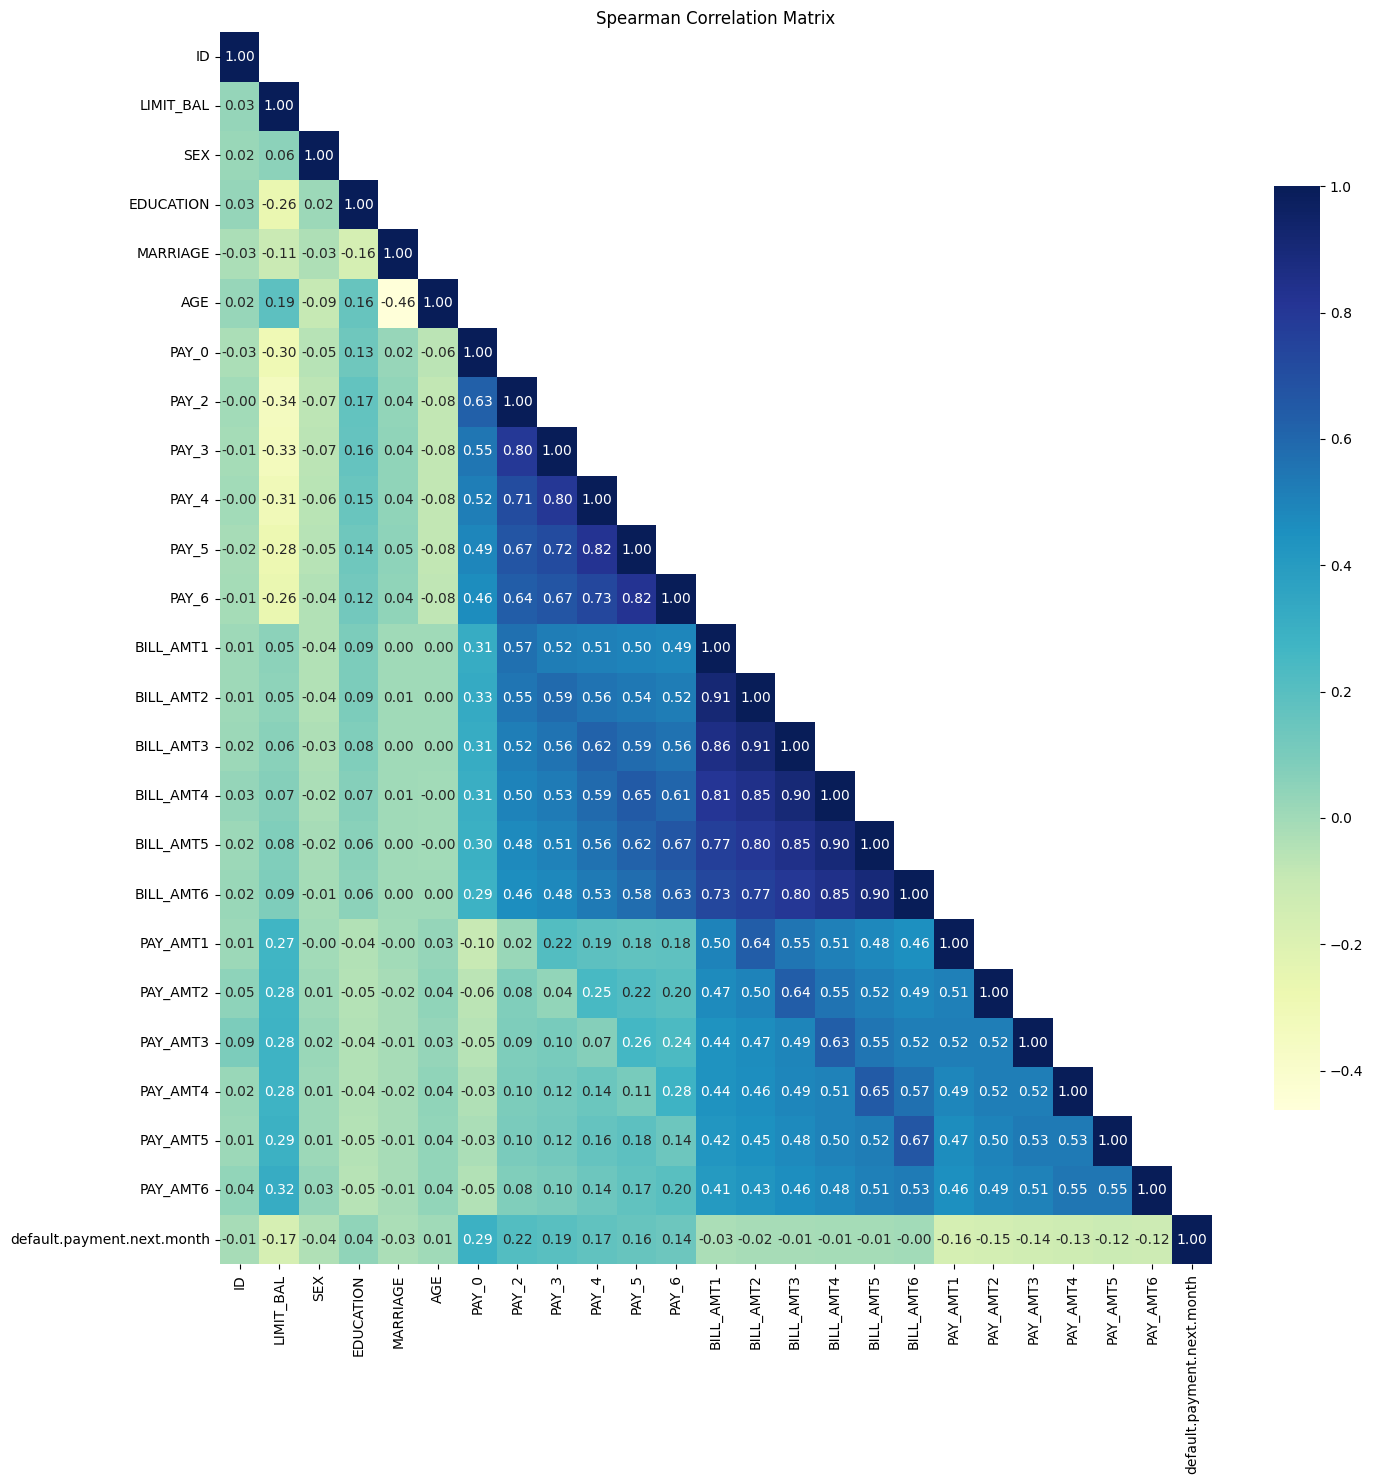

In [63]:
plt.figure(figsize=(16, 16))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(spearman_correlation_matrix, annot=True, fmt=".2f", cmap="YlGnBu", 
            mask = np.triu(spearman_correlation_matrix, 1), cbar_kws={"shrink": .75})

plt.title('Spearman Correlation Matrix')
plt.show()


From this heatmap, you can see that:

- The repayment status features (`PAY_0` to `PAY_6`) have strong positive correlations with each other and with the target variable `default.payment.next.month`.
- `LIMIT_BAL` shows a negative correlation with the repayment status features and the target variable.
- The amount of bill statement (`BILL_AMT1` to `BILL_AMT6`) and amount paid (`PAY_AMT1` to `PAY_AMT6`) show weaker correlations with the target variable but have inter-correlations amongst themselves.

# 3. Modelling

## 3.1 Let's begin simple (Decision Tree w/ depth = 1)

To evaluate the predictive power of the feature `PAY_0`, we will check if using it with a simple DT with depth = 1 is enough to make a good prediction of defaults. This will be our ***base model***

In [8]:
# Define feature and target variables
X = df[['PAY_0']]
y = df[target]

# Split the data into training and test sets (30% reserved for test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a Decision Tree classifier with maximum depth of 1
clf = DecisionTreeClassifier(max_depth=1, random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Predict the target for the test set
y_pred = clf.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Compute ROC curve and area under the curve (AUC)
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

conf_matrix, accuracy, precision, recall, f1, roc_auc


(array([[6755,  285],
        [1335,  625]]),
 0.82,
 0.6868131868131868,
 0.31887755102040816,
 0.4355400696864111,
 0.6391972982374767)

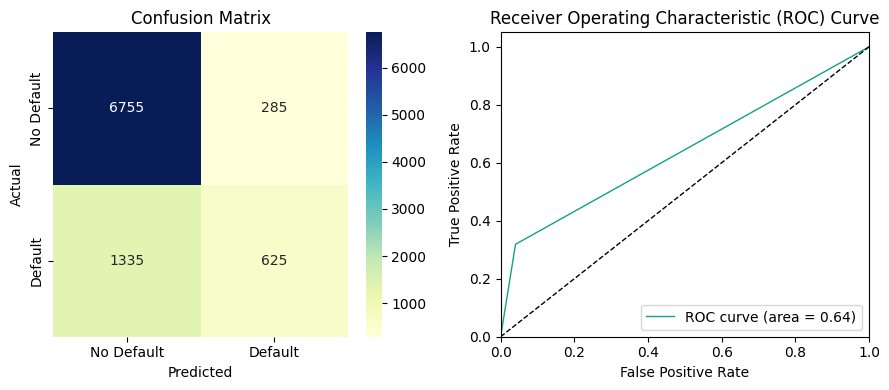

In [9]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'], 
            ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# Plot ROC Curve
axes[1].plot(fpr, tpr, color='#14a27f', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

- The **accuracy** is relatively high at 82%, but this is ***misleading*** given the class imbalance.
- The **recall** is low at approximately 31.9%, suggesting the model misses more than two thirds of actual defaults, a significant proportion.
- The **ROC AUC** is moderate, indicating that the model has some discriminative power but is far from perfect.

Using only the highest correlated feature (`PAY_0`) gives us a starting point, but it might not be sufficient for a reliable prediction. The low recall suggests that the model could benefit from including more features.

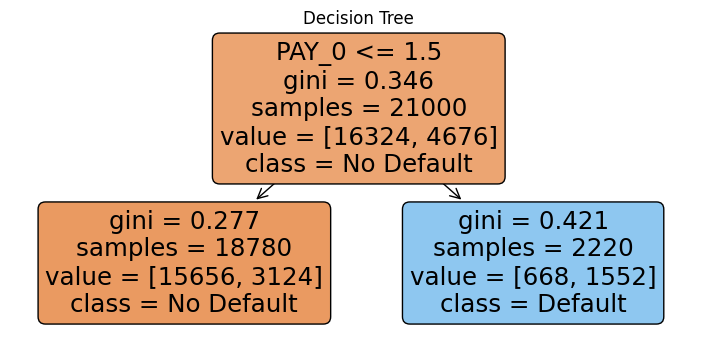

In [10]:
# Plot the base Decision Tree model
plt.figure(figsize=(9, 4))
plot_tree(clf, feature_names=['PAY_0'], class_names=['No Default', 'Default'], filled=True, rounded=True)
plt.title('Decision Tree')
plt.show()

In the context of this dataset, the `PAY_0` feature represents the repayment status in the most recent month, with the scale ranging from -2 to 8:

The decision tree's root node split at `PAY_0` $\leq 1.5 $ essentially divides the data into two groups:

1. `PAY_0` $ \leq 1.5 $: This group includes individuals who have either:
    - Paid off their balance in full (-1),
    - Not consumed any credit (-2),
    - Made use of revolving credit without necessarily paying off their balance (0), or
    - Delayed their payment for one month (1).
   
   This group is labeled as "No Default" by the decision tree, indicating a lower likelihood of defaulting the next month.

2. `PAY_0` $ > 1.5 $: This group includes individuals who have delayed their payments for more than one month (values from 2 to 8). The decision tree labels this group as "Default," indicating a higher likelihood of defaulting the next month.

The threshold of 1.5 serves as a simple, yet powerful, way to segregate those who are more likely to default from those who are less likely, based solely on their most recent repayment status.

## 3.2 Increasing complexity (Random Forest w/ all features)

Let's now try a random forest (ensemble of decision trees) with all features and compare its result with the base model's (the simple DT)

In [11]:
# Define feature and target variables
X_all = df.drop(['ID', target], axis=1)
y_all = df[target]

# Split the data into training and test sets (30% reserved for test)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

# Initialize a Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=1000, random_state=42)

# Fit the model
clf_rf.fit(X_train_all, y_train_all)

# Predict the target for the test set
y_pred_all = clf_rf.predict(X_test_all)

# Compute the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_all, y_pred_all)

# Compute the evaluation metrics
accuracy_rf = accuracy_score(y_test_all, y_pred_all)
precision_rf = precision_score(y_test_all, y_pred_all)
recall_rf = recall_score(y_test_all, y_pred_all)
f1_rf = f1_score(y_test_all, y_pred_all)

# Compute ROC curve and area under the curve (AUC)
fpr_rf, tpr_rf, _ = roc_curve(y_test_all, clf_rf.predict_proba(X_test_all)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

conf_matrix_rf, accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf

(array([[6616,  424],
        [1239,  721]]),
 0.8152222222222222,
 0.6296943231441048,
 0.3678571428571429,
 0.4644122383252818,
 0.7605621303919295)

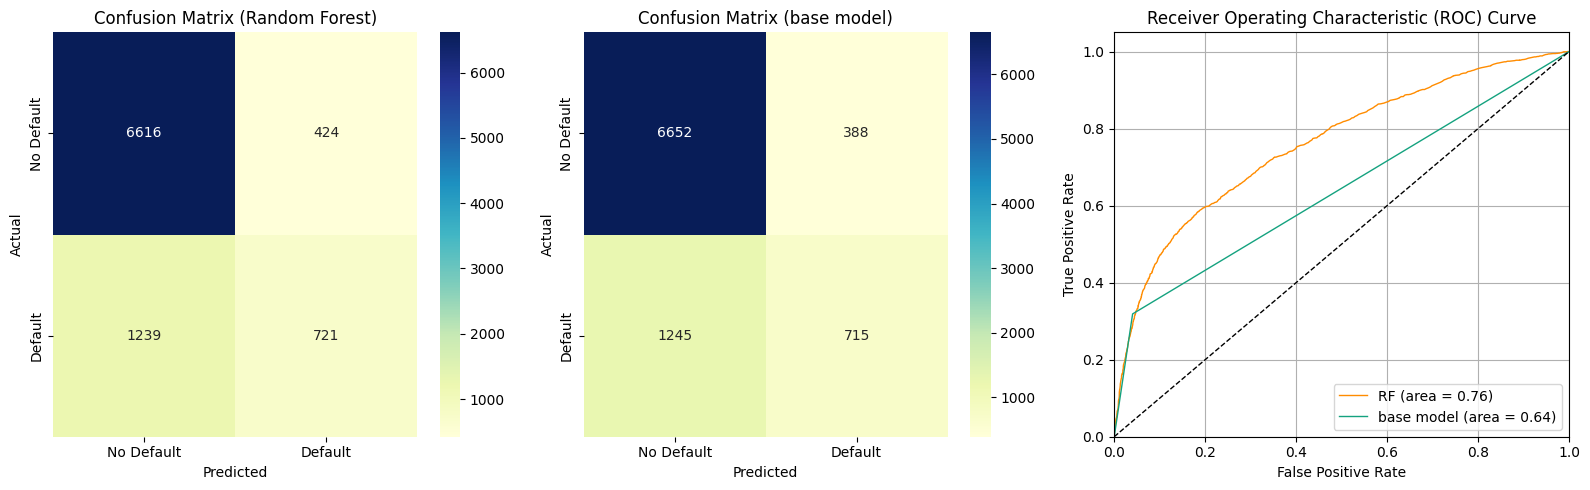

In [65]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot Confusion Matrix for Random Forest
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'], 
            ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Random Forest)')

# Plot Confusion Matrix for base model
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'], 
            ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (base model)')

# Plot ROC Curve for Random Forest
axes[2].plot(fpr_rf, tpr_rf, color='darkorange', lw=1, label='RF (area = %0.2f)' % roc_auc_rf)
axes[2].plot(fpr, tpr, color='#14a27f', lw=1, label='base model (area = %0.2f)' % roc_auc)
axes[2].plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[2].legend(loc="lower right")
axes[2].grid()

plt.tight_layout()
plt.show()

- The Random Forest model has a **higher ROC AUC** ($0.76$) compared to the base model ($0.639$).
- The number of False Negatives (1239) is still relatively high, but less than in the base model (1335).
- The Random Forest model has a **higher recall** ($36.7\%$) compared to the base model ($31.9\%$).
- The RF model has a ***lower precision*** ($63.0\%$) compared to the base model ($68.7\%$).

## 3.3 Meeting half-way (Random Forest with only the most important features)
Let's now make a feature selection with RFE to check if using only a subset of features might give a better performance for the RF model

In [13]:
# Initialize the Random Forest classifier
rf_estimator = RandomForestClassifier(random_state=42)

# Initialize RFE with the Random Forest estimator and step=1 (remove one feature at a time)
selector = RFE(rf_estimator, step=1, verbose=1)

# Fit the feature selector
selector = selector.fit(X_train_all, y_train_all)

# Get the ranking of features
feature_ranking = selector.ranking_

# Create a DataFrame to display feature names and their ranking
feature_ranking_df = pd.DataFrame({'Feature': X_all.columns, 'Ranking': feature_ranking}).sort_values(by='Ranking')

# Show features sorted by their ranking
feature_ranking_df

Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


,Feature,Ranking
0,LIMIT_BAL,1
18,PAY_AMT2,1
17,PAY_AMT1,1
16,BILL_AMT6,1
15,BILL_AMT5,1
14,BILL_AMT4,1
13,BILL_AMT3,1
12,BILL_AMT2,1
11,BILL_AMT1,1
5,PAY_0,1


In [22]:
# Filter the dataset to only include top-ranked features
top_features = feature_ranking_df[feature_ranking_df['Ranking'] == 1]['Feature'].values
X_top = df[top_features]
y_top = df[target]

# Split the data into training and test sets (30% reserved for test)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, test_size=0.3, random_state=42)

# Initialize and fit the Random Forest classifier
clf_rf_top = RandomForestClassifier(n_estimators=1000, random_state=42)
clf_rf_top.fit(X_train_top, y_train_top)

# Predict the target for the test set
y_pred_top = clf_rf_top.predict(X_test_top)

# Compute the confusion matrix
conf_matrix_rf_top = confusion_matrix(y_test_top, y_pred_top)

# Compute the accuracy and recall
accuracy_rf_top = accuracy_score(y_test_top, y_pred_top)
recall_rf_top = recall_score(y_test_top, y_pred_top)

# Compute F1-score and precision
f1_rf_top = f1_score(y_test_top, y_pred_top)
precision_rf_top = precision_score(y_test_top, y_pred_top)

# Compute ROC curve and area under the curve (AUC)
fpr_rf_top, tpr_rf_top, _ = roc_curve(y_test_top, clf_rf_top.predict_proba(X_test_top)[:, 1])
roc_auc_rf_top = auc(fpr_rf_top, tpr_rf_top)

conf_matrix_rf_top, accuracy_rf_top, precision_rf_top, recall_rf_top, f1_rf_top, roc_auc_rf_top

(array([[6623,  417],
        [1274,  686]]),
 0.8121111111111111,
 0.6219401631912964,
 0.35,
 0.4479268690825987,
 0.7450279017857143)

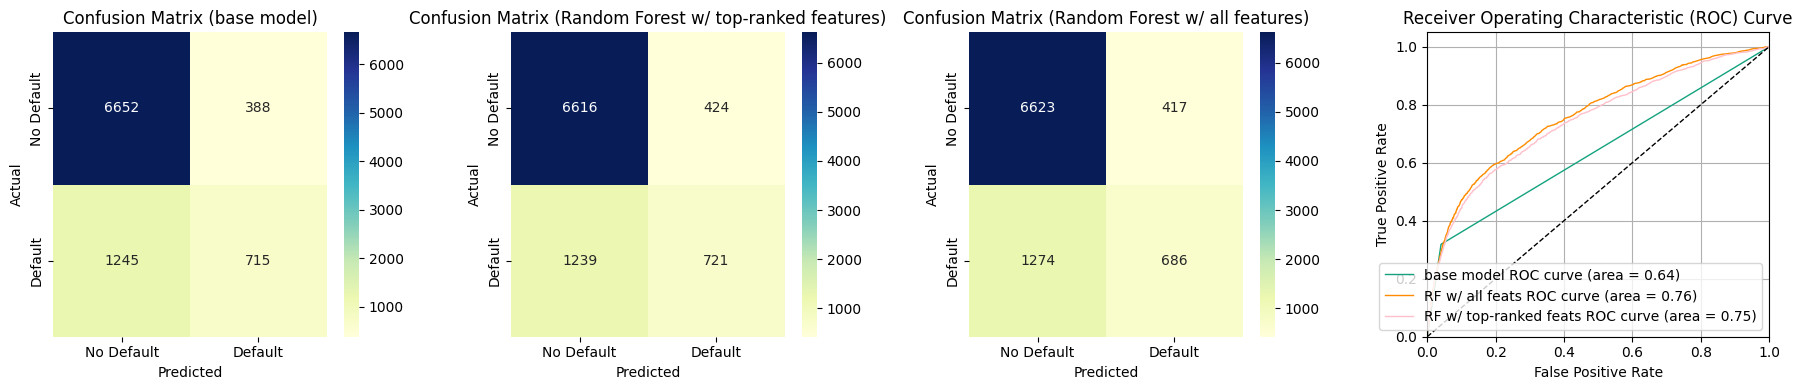

In [64]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# Plot Confusion Matrix for base model
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'], 
            ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (base model)')

# Plot Confusion Matrix for Random Forest with top-ranked features
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'], 
            ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Random Forest w/ top-ranked features)')

# Plot Confusion Matrix for Random Forest with all features
sns.heatmap(conf_matrix_rf_top, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'], 
            ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Confusion Matrix (Random Forest w/ all features)')

# Plot ROC Curve for Random Forest
axes[3].plot(fpr, tpr, color='#14a27f', lw=1, label='base model (area = %0.2f)' % roc_auc)
axes[3].plot(fpr_rf, tpr_rf, color='darkorange', lw=1, label='RF w/ all feats (area = %0.2f)' % roc_auc_rf)
axes[3].plot(fpr_rf_top, tpr_rf_top, color='pink', lw=1, label='RF w/ top-ranked feats (area = %0.2f)' % roc_auc_rf_top)
axes[3].plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
axes[3].set_xlim([0.0, 1.0])
axes[3].set_ylim([0.0, 1.05])
axes[3].set_xlabel('False Positive Rate')
axes[3].set_ylabel('True Positive Rate')
axes[3].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[3].legend(loc="lower right")
axes[3].grid()

plt.tight_layout()
plt.show()


## 3.4 Trying Boosting (CatBoost w/ all features)
Let's now try CatBoost to compare the emsemble method to a boosting method

In [48]:
# Initialize CatBoost
clf_catboost = CatBoostClassifier(random_seed=42, verbose=0)  # verbose=0 turns off the training output

# Fit the model
clf_catboost.fit(X_train_all, y_train_all)
# Predict the target for the test set
y_pred_catboost = clf_catboost.predict(X_test_all)

# Compute the confusion matrix
conf_matrix_cat = confusion_matrix(y_test_all, y_pred_catboost)

# Compute the accuracy and recall
accuracy_cat = accuracy_score(y_test_all, y_pred_catboost)
recall_cat = recall_score(y_test_all, y_pred_catboost)

# Compute F1-score and precision
f1_cat = f1_score(y_test_all, y_pred_catboost)
precision_cat = precision_score(y_test_all, y_pred_catboost)

# Compute ROC curve and area under the curve (AUC)
fpr_cat, tpr_cat, _ = roc_curve(y_test_all, clf_catboost.predict_proba(X_test_all)[:, 1])
roc_auc_cat = auc(fpr_cat, tpr_cat)

conf_matrix_cat, accuracy_cat, precision_cat, recall_cat, f1_cat, roc_auc_cat

(array([[6652,  388],
        [1245,  715]]),
 0.8185555555555556,
 0.6482320942883046,
 0.3647959183673469,
 0.46686255305256286,
 0.7757064587198517)

# 4. Final Results

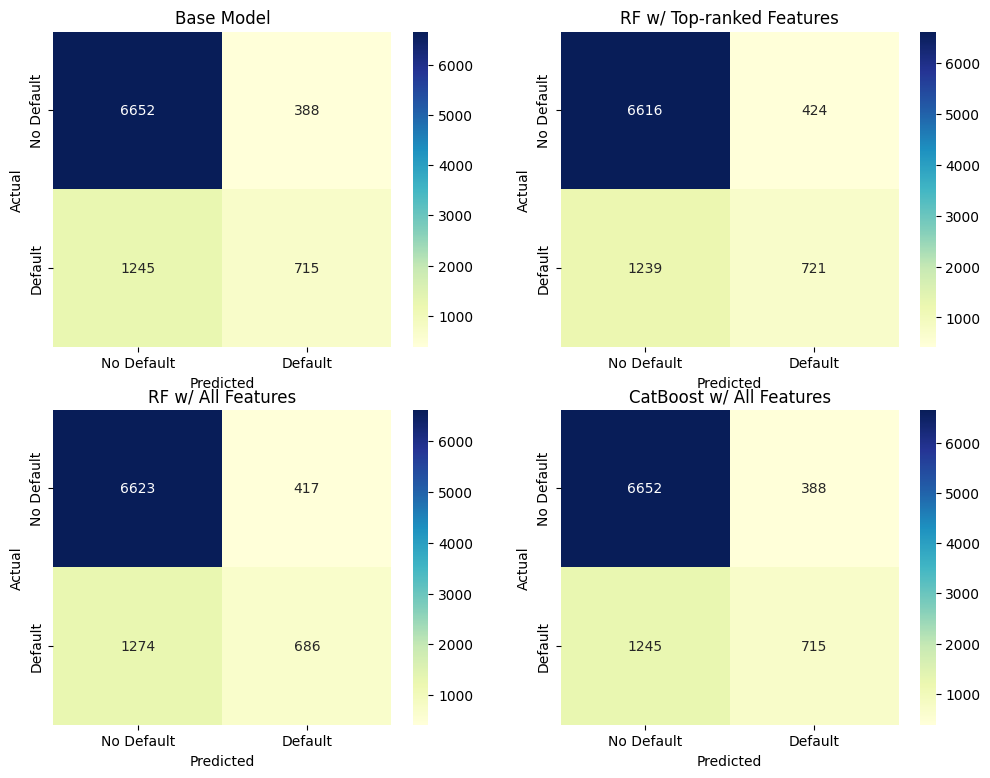

In [30]:

# --- Plot Confusion Matrices ---
fig1, axes1 = plt.subplots(2, 2, figsize=(12, 9))

# Create an array of titles and confusion matrices
titles = ['Base Model', 'RF w/ Top-ranked Features', 'RF w/ All Features', 'CatBoost w/ All Features']
conf_matrices = [conf_matrix, conf_matrix_rf, conf_matrix_rf_top, conf_matrix_cat]

# Loop through the 2x2 grid and plot each confusion matrix
for ax, title, conf_matrix in zip(axes1.flatten(), titles, conf_matrices):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'], ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


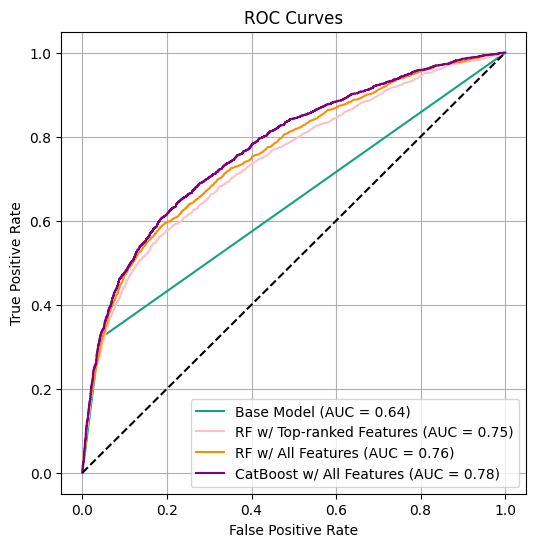

In [38]:
# --- Plot ROC Curves ---
fig2, ax2 = plt.subplots(figsize=(6, 6))

# Plot each ROC curve
ax2.plot(fpr, tpr, label=f'Base Model (AUC = {roc_auc:.2f})', color='#14a27f')
ax2.plot(fpr_rf_top, tpr_rf_top, label=f'RF w/ Top-ranked Features (AUC = {roc_auc_rf_top:.2f})', color='pink')
ax2.plot(fpr_rf, tpr_rf, label=f'RF w/ All Features (AUC = {roc_auc_rf:.2f})', color='darkorange')
ax2.plot(fpr_cat, tpr_cat, label=f'CatBoost w/ All Features (AUC = {roc_auc_cat:.2f})', color='purple')

# Plot the random classifier line
ax2.plot([0, 1], [0, 1], linestyle='--', color='k')

# Set labels and title
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend(loc='lower right')
ax2.grid()

# 5. Conclusions

| Metric                  | Base Model (Decision Tree w/ only `PAY_0`) | Random Forest (Top-ranked Features) | Random Forest (All features) | CatBoost (All features) |
|-------------------------|----------------------------|------------------------------|-------------------------------------|--------------------------|
| **Accuracy**            |  82.0\%  ☑️              |  81.2\%                    |  81.5\%                           |  81.9\%                 |
| **Recall**              |  31.9\%                  |  35.0\%                    |  36.8\%  ☑️                       |  36.5\%                |
| **Precision**           |  68.7\%  ☑️               |  62.2\%                    |  63.0\%                           |  64.8\% 
| **F1-Score**            |  42.1\%                  |  44.8\%                    |  46.4\%                         |  46.7\% ☑️
| **ROC AUC**             |  0.639                   |  0.745                     |  0.761  ☑️                        |  0.776                 |

## Conclusions

### When Prioritizing Recall (Finding All Defaults - No False Negatives):
- **Metric of Interest**: Recall
- **Best Model**: Random Forest (All features) with a recall of  36.8\% , closely followed by CatBoost with  36.5\% .

If the goal is to identify all individuals who will default, even at the risk of including some who won't, then the Random Forest model with all features is slightly better, although CatBoost is a close second.

### When Prioritizing Precision (Avoiding False Positives - No Headaches for Non-Default Clients):
- **Metric of Interest**: Precision
- **Best Model**: Base Model (Decision Tree w/ only `PAY_0`) with a precision of  68.7\% .

If the goal is to minimize false positives to avoid causing issues for non-defaulting clients, then the Base Model with only `PAY_0` is the best choice, as it has the highest precision.

### Summary:
- For **maximizing recall**, use the **Random Forest model with all features**.
- For **maximizing precision**, use the **Base Model with only `PAY_0`**.
- **CatBoost** also performs quite well and could be considered for scenarios where a **balance between recall** and precision is needed.

# Extra 1
What if we only use the personal data of people? i.e. ```'SEX', 'AGE', 'EDUCATION', 'MARRIAGE'```?

In [49]:
# Subset the training and testing data
X_train_subset = X_train_all[['SEX', 'AGE', 'EDUCATION', 'MARRIAGE']]
X_test_subset = X_test_all[['SEX', 'AGE', 'EDUCATION', 'MARRIAGE']]

# Initialize CatBoost
clf_catboost_subset = CatBoostClassifier(random_seed=42, verbose=0)

# Fit the model to the subsetted data
clf_catboost_subset.fit(X_train_subset, y_train_all)

# Make predictions on the test set
y_pred_subset = clf_catboost_subset.predict(X_test_subset)

# Compute the confusion matrix
conf_matrix_subset = confusion_matrix(y_test_all, y_pred_subset)

# Compute the accuracy and recall
accuracy_subset = accuracy_score(y_test_all, y_pred_subset)
recall_subset = recall_score(y_test_all, y_pred_subset)

# Compute F1-score and precision
f1_subset = f1_score(y_test_all, y_pred_subset)
precision_subset = precision_score(y_test_all, y_pred_subset)

# Compute ROC curve and area under the curve (AUC)
fpr_subset, tpr_subset, _ = roc_curve(y_test_all, clf_catboost_subset.predict_proba(X_test_subset)[:, 1])
roc_auc_subset = auc(fpr_subset, tpr_subset)


conf_matrix_subset, accuracy_subset, precision_subset, recall_subset, f1_subset, roc_auc_subset

(array([[7021,   19],
        [1954,    6]]),
 0.7807777777777778,
 0.24,
 0.003061224489795918,
 0.006045340050377834,
 0.5511360737476809)

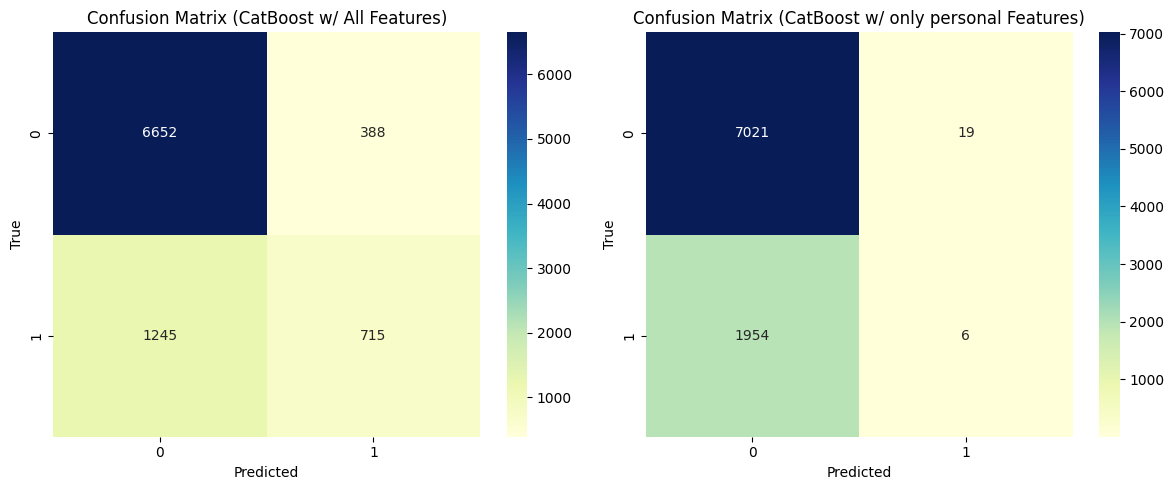

In [59]:
# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# CatBoost with all features
sns.heatmap(conf_matrix_cat, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0])
axes[0].set_title('Confusion Matrix (CatBoost w/ All Features)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# CatBoost with subset features
sns.heatmap(conf_matrix_subset, annot=True, fmt='d', cmap='YlGnBu', ax=axes[1])
axes[1].set_title('Confusion Matrix (CatBoost w/ only personal Features)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

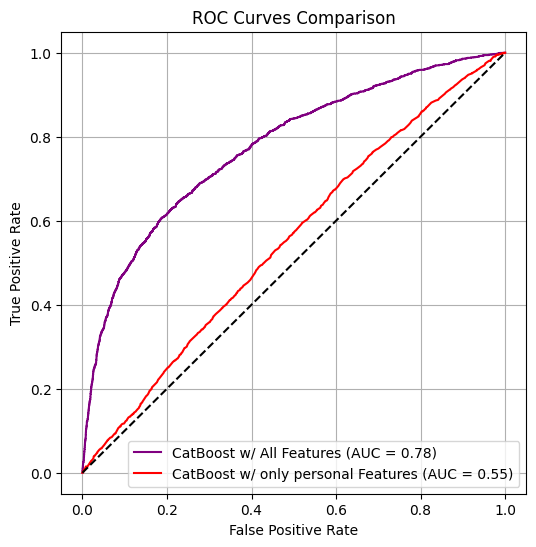

In [60]:
# Plot ROC Curves
fig, ax = plt.subplots(figsize=(6, 6))

# CatBoost with all features
ax.plot(fpr_cat, tpr_cat, label=f'CatBoost w/ All Features (AUC = {roc_auc_cat:.2f})', color='purple')

# CatBoost with subset features
ax.plot(fpr_subset, tpr_subset, label=f'CatBoost w/ only personal Features (AUC = {roc_auc_subset:.2f})', color='r')

# Random classifier
ax.plot([0, 1], [0, 1], linestyle='--', color='k')

# Labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison')
ax.legend(loc='lower right')
ax.grid()

plt.show()

***Answer***: the personal data of people should not be used alone when making such model

# Extra 2:

SHAP Analysis

In [42]:
shap_data = Pool(X_test_all, label=y_test_all)
shap_values = clf_catboost.get_feature_importance(data=shap_data, type='ShapValues')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


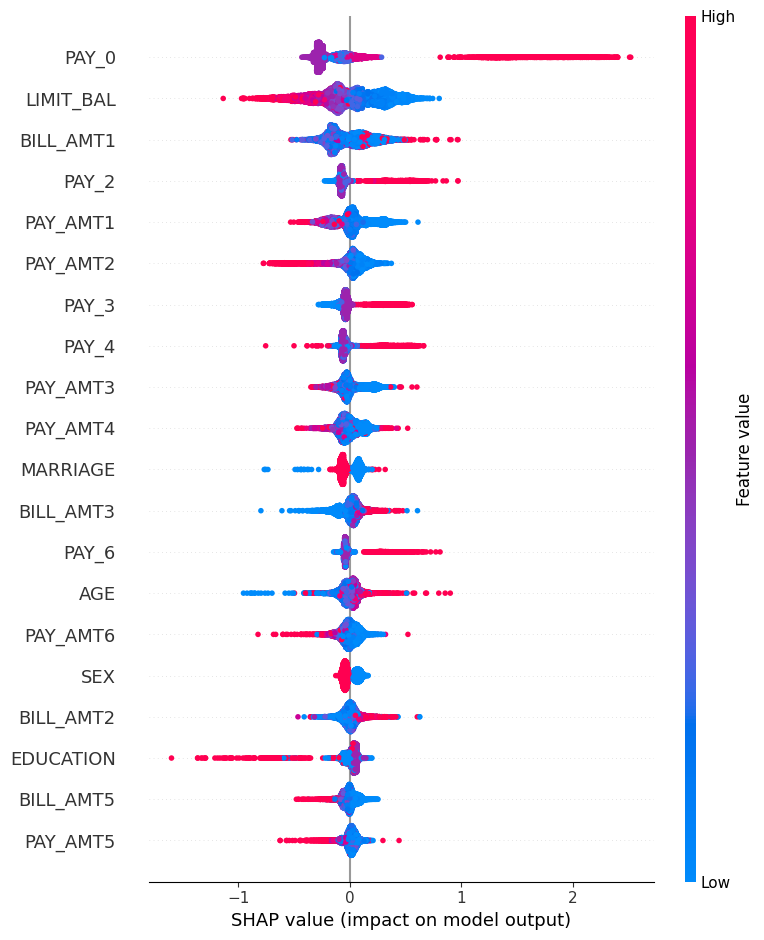

In [44]:
# Summarize the SHAP values in a plot
shap.summary_plot(shap_values[:, :-1], X_test_all)